In [1]:
import os
import tqdm 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/yerdaulet/Documents/bee/VAE/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Dataset preparation

In [2]:
# Define transformations (normalize pixel values to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(
    root='./data',  # Directory to save the dataset
    train=True,     # Load the training set
    transform=transform,
    download=True   # Download the dataset if not already available
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,    # Load the test set
    transform=transform,
    download=True
)

# Data loaders for batch processing
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Batch size
    shuffle=True    # Shuffle the data for training
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False   # No need to shuffle for testing
)

# Variational Auto Encoder's Theory


### Resources: 
https://arxiv.org/pdf/1312.6114

https://www.youtube.com/watch?v=YV9D3TWY5Zo



<center>
<img src="images/1.png" alt="Image" width="700" height="300", title="VAE">
<br>
<label><h5>High reconstruction error indicates an anomaly, <br>meaning the input data is different from the data the network has seen during training</h5></label>
<br>
<img src="images/2.png" alt="Image" width="700" height="300", title="VAE">
<br>

<label><h5>The left graph represents a normal AE, while the right one represents a VAE.</h5></label>
</center>
Normal AE is not robust when the image is slightly different from the data it has seen during training. <br>
It has an unknown distribution of the latent space, and there is no possibility of smooth transformation of the reconstruction. <br>
If the decoder receives a noisy latent vector, it returns noise as well. <br>
Working with an unknown distribution is extremely difficult, <br>
so we need to regularize the latent vector distribution to a well-known Gaussian distribution using KL divergence (two distribution similarity score)
</label>
<br>
<br>

<center>
<img src="images/3.png" alt="Image" width="800" height="400", title="VAE">
<br>
</center>
<center>
<img src="images/4.png" alt="Image" width="600" height="300", title="VAE">
<br>
<h5>Issue: Backpropagation through a randomized latent vector from a Gaussian distribution <br>with learned mean and standard deviation values from the encoder <br></h5>
</center>

<center><h5>Reparametrization trick solves the backpropogation issue</h5>
<img src="images/5.png" alt="Image" width="700" height="400", title="VAE">

<label>Encoder needs to learn to describe the mean and std of a latent vector</label>
</center>

<br>
<center>
<img src="images/6.png" alt="Image" width="800" height="800", title="Paper">

</center>



##### Loss function: Reconstruction loss + KL divergence loss

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            # nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1), 
            # nn.ReLU(),
            nn.Flatten(),
        )
        
        self.fc_mu = nn.Linear(27, 2)
        self.fc_logvar = nn.Linear(27, 2)

        # Decoder network88
        self.fc_decode = nn.Linear(2, 27)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (3, 3, 3)),
            nn.ConvTranspose2d(3, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=0),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),    
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     
            nn.Sigmoid(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Convert logvar to standard deviation (std)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc_decode(z)
        x_reconstructed = self.decoder(h3)
        return x_reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

def loss_function(reconstructed_x, x, mu, logvar):
    # Binary Cross-Entropy (BCE) loss for reconstruction + KL divergence loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    # MSE = F.mse_loss(input=reconstructed_x, target=x, reduction='sum')
    # KL Divergence losssum
    # Equation for KL divergence between normal distribution and learned distribution
    # D_KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma is exp(logvar / 2)
    # We are working with the N(0,1) as the prior
    # This loss is summed over all pixels in the image
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL_divergence


# vae = VAE()
# vae(imgs.cpu())[0].shape
# input_image = torch.ones((1, 1, 28, 28))
# vae(input_image)[0].shape
# reconstructed_image, mu, logvar = vae(imgs[:])
# loss_function(reconstructed_image, imgs[:], mu, logvar)

In [4]:
os.makedirs("models_mnist/", exist_ok=True)

def save_best_model(vae, lowest_val_loss, epoch, train_loss, val_loss):
    torch.save({
        "epoch": epoch,
        "train_loss": round(train_loss, 2),
        "val_loss": round(val_loss, 2),
        "state_dict": vae.state_dict(),
    }, f"models_mnist/last_model.pt")
    
    if lowest_val_loss > val_loss:
        torch.save({
            "epoch": epoch,
            "train_loss": round(train_loss, 2),
            "val_loss": round(val_loss, 2),
            "state_dict": vae.state_dict(),
        }, f"models_mnist/best_model_{epoch}_t_{train_loss}_v_{val_loss}.pt")
        print(f"The best model was saved with val_loss: {val_loss}")
        return val_loss
    return lowest_val_loss

In [5]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [6]:
iterations = 20
lowest_val_loss = torch.inf
train_loss, val_loss = [], []


for epoch in tqdm.trange(iterations):
    vae.train()
    epoch_loss, count = 0, 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        reconstructed_mel, mu, logvar = vae(imgs)
        loss = loss_function(reconstructed_mel, imgs, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        count += 1  
    loss = epoch_loss / count
    train_loss.append(loss.item())

    vae.eval()
    with torch.no_grad():
        epoch_loss, count = 0, 0
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            reconstructed_mel, mu, logvar = vae(imgs)
            loss = loss_function(reconstructed_mel, imgs, mu, logvar)
            epoch_loss += loss
            count += 1
        loss = epoch_loss / count
        val_loss.append(loss.item())

    lowest_val_loss = save_best_model(vae, lowest_val_loss, epoch, train_loss[-1], val_loss[-1])
    print(f"Epoch: {epoch} | training loss: {train_loss[-1]:.2f} | validation loss: {val_loss[-1]:.2f}")


  5%|▌         | 1/20 [00:44<13:57, 44.09s/it]

The best model was saved with val_loss: 10818.302734375
Epoch: 0 | training loss: 12200.50 | validation loss: 10818.30


 10%|█         | 2/20 [01:18<11:30, 38.35s/it]

The best model was saved with val_loss: 10374.2783203125
Epoch: 1 | training loss: 10637.01 | validation loss: 10374.28


 15%|█▌        | 3/20 [01:52<10:21, 36.54s/it]

The best model was saved with val_loss: 10145.2119140625
Epoch: 2 | training loss: 10311.78 | validation loss: 10145.21


 20%|██        | 4/20 [02:26<09:28, 35.53s/it]

The best model was saved with val_loss: 10059.8857421875
Epoch: 3 | training loss: 10140.46 | validation loss: 10059.89


 25%|██▌       | 5/20 [03:01<08:47, 35.13s/it]

The best model was saved with val_loss: 9930.716796875
Epoch: 4 | training loss: 10032.85 | validation loss: 9930.72


 30%|███       | 6/20 [03:35<08:08, 34.88s/it]

The best model was saved with val_loss: 9926.8447265625
Epoch: 5 | training loss: 9949.07 | validation loss: 9926.84


 35%|███▌      | 7/20 [04:09<07:30, 34.68s/it]

The best model was saved with val_loss: 9875.947265625
Epoch: 6 | training loss: 9887.83 | validation loss: 9875.95


 40%|████      | 8/20 [04:44<06:54, 34.51s/it]

The best model was saved with val_loss: 9772.4912109375
Epoch: 7 | training loss: 9829.07 | validation loss: 9772.49


 45%|████▌     | 9/20 [05:18<06:17, 34.35s/it]

The best model was saved with val_loss: 9769.8701171875
Epoch: 8 | training loss: 9788.48 | validation loss: 9769.87


 50%|█████     | 10/20 [05:52<05:44, 34.45s/it]

The best model was saved with val_loss: 9747.5712890625
Epoch: 9 | training loss: 9750.28 | validation loss: 9747.57


 55%|█████▌    | 11/20 [06:26<05:09, 34.38s/it]

The best model was saved with val_loss: 9730.9072265625
Epoch: 10 | training loss: 9717.52 | validation loss: 9730.91


 60%|██████    | 12/20 [07:00<04:34, 34.27s/it]

The best model was saved with val_loss: 9633.6318359375
Epoch: 11 | training loss: 9690.03 | validation loss: 9633.63


 65%|██████▌   | 13/20 [07:34<03:59, 34.19s/it]

Epoch: 12 | training loss: 9663.61 | validation loss: 9691.36


 70%|███████   | 14/20 [08:08<03:24, 34.12s/it]

The best model was saved with val_loss: 9632.2861328125
Epoch: 13 | training loss: 9643.19 | validation loss: 9632.29


 75%|███████▌  | 15/20 [08:43<02:52, 34.40s/it]

Epoch: 14 | training loss: 9624.30 | validation loss: 9636.07


 80%|████████  | 16/20 [09:18<02:17, 34.31s/it]

The best model was saved with val_loss: 9617.248046875
Epoch: 15 | training loss: 9602.41 | validation loss: 9617.25


 85%|████████▌ | 17/20 [09:52<01:43, 34.46s/it]

Epoch: 16 | training loss: 9585.33 | validation loss: 9739.61


 90%|█████████ | 18/20 [10:27<01:09, 34.60s/it]

Epoch: 17 | training loss: 9569.87 | validation loss: 9636.02


 95%|█████████▌| 19/20 [11:02<00:34, 34.54s/it]

The best model was saved with val_loss: 9554.8623046875
Epoch: 18 | training loss: 9552.82 | validation loss: 9554.86


100%|██████████| 20/20 [11:36<00:00, 34.82s/it]

The best model was saved with val_loss: 9537.3115234375
Epoch: 19 | training loss: 9542.13 | validation loss: 9537.31


In [ ]:
# pd.DataFrame({
#     "epoch": range(len(train_loss)),
#     "train_loss": train_loss,
#     "val_loss": val_loss
# }).to_csv('mnist_vae_loss.csv', index=False)

In [9]:
vae.eval().cpu();
vae.load_state_dict(torch.load('models_mnist/best_model_19_t_9542.1279296875_v_9537.3115234375.pt')['state_dict'])

/tmp/ipykernel_58310/1659441775.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('models_mnist/best_model_19_t_9542.1279296875_v_9537.31152

<All keys matched successfully>

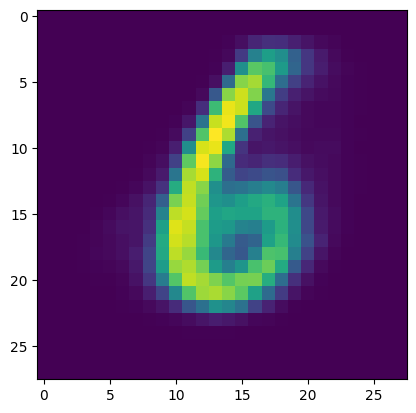

In [12]:
image = vae.decode(torch.tensor(([[0.7, 0.8]]), dtype=torch.float32, device='cpu'))
plt.imshow(image.detach().cpu().squeeze(0).permute(1, 2, 0))

In [22]:
with torch.no_grad():
    out, m, std = vae(imgs)

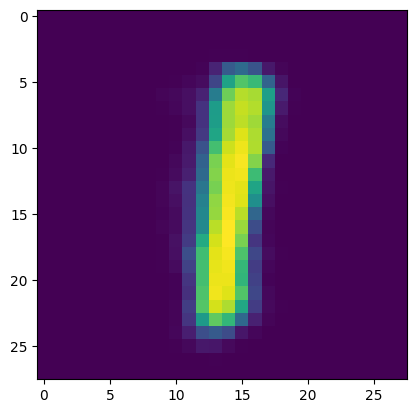

In [23]:
plt.imshow(out[0].permute(1,2,0))

In [26]:
F.binary_cross_entropy(input=out[0], target=imgs[0], reduction='mean')

tensor(0.0667)